# Evaluation of Results of "TUD-MMC at MediaEval 2016: Context of Experience task" by Wang & Liem

## Necessary imports

In [1]:
import pandas as pd
import numpy as np
import os.path
import xml.etree.ElementTree as ET

train_path = "res/coe_dataset_icpr/dev_set/"
test_path = "res/coe_dataset_icpr/test_set/"

audio_folder = "audio_descriptors/"
text_folder = "text_descriptors/"
vis_folder = "vis_descriptors/"
metadata_folder = "XML/"

train_entries_path = "res/CoeTraining.csv"

## Datasets

Features are built in the manner described in the paper of Wang & Liem or "Right Inflight? A Dataset for Exploring the Automatic
Prediction of Movies Suitable for a Watching Situation" (https://mmsys2016.itec.aau.at/papers/MMSYS/a45-riegler.pdf), if Wang & Liem do not provide any information.

This leads to following set-up:

Metadata: (language, year published, genre, country, runtime and age rating) - from XML -- 1-Hot Encoding for all categorical values<br>
Text: as is td-idf <br>
Audio: Averaged of all Frames (NaN to 0) - Mel-Frequency Cepstral Coefficients<br>
Visual: as is - Histogram of Oriented Gradients (HOG) gray, Color Moments, local binary patterns (LBP) and Gray Level Run Length Matrix

NOTE: Training data - invalid entry (2_states, also in test set), (Moulin_Rouge!.mp4, should be Moulin_Rouge! --> fixed)

In [2]:
df_base_train = pd.read_csv(train_entries_path)
df_base_train = df_base_train[df_base_train['file_name'] != '2_States'] # remove invalid entry
df_base_train.sort_values(by='file_name', inplace=True)
df_base_train.reset_index(inplace=True, drop=True)
df_targets_train = df_base_train['goodforairplanes'].astype(int)
df_base_train.head(5)

,movie_name,file_name,goodforairplanes
0,A Fish Called Wanda,A_Fish_Called_Wanda,1
1,A Goofy Movie,A_Goofy_Movie,0
2,A Million Ways to Die in the West,A_Million_Ways_to_Die_in_the_West,1
3,A Single Man,A_Single_Man,1
4,American Gangster,American_Gangster,1


## Feature extractors
As the dataset was built in a manner that would have been considered dirty already in 2002 a lot of feature extraction is done

In [3]:
def get_audio_features(file_name, use_train=True):
    """
        returns 1x14 dataframe, with averaged Mel-Frequency Cepstral Coefficients + file_name
    """
    base_path = train_path if use_train else test_path
    file_path = os.path.join(base_path, audio_folder, file_name + ".csv")
    if not os.path.isfile(file_path):
        print(file_name, " does not exist!")
        return pd.DataFrame(columns=[str(x) for x in range(13)] + ['file_name'])
    df_audio = pd.read_csv(file_path, header=None).T # transpose (columns are rows)
    df_audio = df_audio.fillna(0) # nan values are treated as 0
    df_audio = pd.DataFrame(df_audio.mean(axis=0)).T # average accross columns
    df_audio['file_name'] = file_name
    return df_audio

def get_all_audio_features(df, use_train=True):
    """
        returns nx14 dataframe, containing audio features for all movies
    """
    dfs = []
    for file_name in df['file_name']:
        dfs.append(get_audio_features(file_name, use_train))
    
    return pd.concat(dfs).reset_index(drop=True)

def get_all_text_features(df, use_train=True):
    """
        returns nx3284 dataframe, containing tf-idf features for all movies
        the dataset creators messed up - contains several terms multiple times
        ordered alphabetically (?) - Live_Nude_Girls and Transformers__Age_of_Extinction where switched (detected perchance)
    """
    base_path = train_path if use_train else test_path
    file_path = os.path.join(base_path, text_folder, "tdf_idf_dev.csv")
    df_txt = pd.read_csv(file_path)
    # the creators of the dataset missed how csv-files work - so we transpose and drop empty rows to get the correct format
    cols = df_txt.columns 
    df_txt = df_txt.T.dropna()
    df_txt.columns = cols
    df_txt.reset_index(inplace=True, drop=True)
    df_txt['file_name'] = sorted(df['file_name']) # we assume the info to be order alphabetically, as we do not have more info
    return df_txt.reset_index(drop=True)

def get_vis_features(file_name, use_train=True):
    """
        returns 1x1653 dataframe, with unspecified visual features + file_name
        we assume that every single value in the csv is one feature
        this may be wrong, as there are two rows and no documentation (again)
    """
    base_path = train_path if use_train else test_path
    file_path = os.path.join(base_path, vis_folder, file_name + ".csv")
    if not os.path.isfile(file_path):
        print(file_name, " does not exist!")
        return pd.DataFrame(columns=[str(x) for x in range(1652)] + ['file_name'])
    df_vis = pd.read_csv(file_path, header=None)
    df_vis = pd.DataFrame(pd.concat([df_vis.loc[0,:], df_vis.loc[1,:]])).reset_index(drop=True).T # treat each value as single feature (-> no aggregation)
    df_vis['file_name'] = file_name
    return df_vis

def get_all_vis_features(df, use_train=True):
    """
        returns nx1653 dataframe, containing visual features for all movies
    """
    dfs = []
    for file_name in df['file_name']:
        dfs.append(get_vis_features(file_name, use_train))
    
    return pd.concat(dfs).reset_index(drop=True)

def get_meta_features(file_name, use_train=True):
    """
        returns 1x7 dataframe, with metadata features + file_name
        One Hot Encoding is not applied here, this should happen later
    """
    base_path = train_path if use_train else test_path
    file_path = os.path.join(base_path, metadata_folder, file_name + ".xml")
    if not os.path.isfile(file_path):
        print(file_name, " does not exist!")
        return pd.DataFrame(columns=['country', 'genre', 'language', 'rated', 'runtime', 'year', 'file_name'])
    etree = ET.parse(file_path)
    movie = etree.getroot().find('movie')
    mv = {}
    mv['language'] = [movie.get('language')]
    mv['year'] = [int(movie.get('year'))]
    mv['genre'] = [movie.get('genre')]
    mv['country'] = [movie.get('country')]
    mv['runtime'] = [int(movie.get('runtime')[:-4])]
    mv['rated'] = [movie.get('rated')]

    df_meta = pd.DataFrame.from_dict(mv)
    df_meta['file_name'] = file_name
    
    return df_meta

def get_all_meta_features(df, use_train=True):
    """
        returns nx7 dataframe, containing metadata features for all movies
    """
    dfs = []
    for file_name in df['file_name']:
        dfs.append(get_meta_features(file_name, use_train))
    
    df_meta = pd.concat(dfs)
    
    df_country = df_meta.country.str.replace(' ','').str.get_dummies(sep=',')
    df_country.columns = ['country_' + x for x in df_country.columns]

    df_genre = df_meta.genre.str.replace(' ','').str.get_dummies(sep=',')
    df_genre.columns = ['genre_' + x for x in df_genre.columns]

    df_language = df_meta.language.str.replace(' ','').str.get_dummies(sep=',')
    df_language.columns = ['language_' + x for x in df_language.columns]

    df_rated = df_meta.rated.str.get_dummies(sep=',')
    df_rated.columns = ['rated_' + x for x in df_rated.columns]
    
    return pd.concat([df_country, df_genre, df_language, df_rated, df_meta[['runtime', 'year', 'file_name']]], axis=1).reset_index(drop=True)

In [4]:
df_audio_train = get_all_audio_features(df_base_train)
df_audio_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,file_name
0,66.828814,-5.674521,1.670346,1.143263,-0.635255,1.269376,0.633811,0.012407,0.164257,-1.494813,-0.292583,0.086875,-0.914582,A_Fish_Called_Wanda
1,43.908715,-6.380989,1.361790,-1.483354,-0.670040,-1.626537,0.466197,-1.888169,0.848654,-0.990286,0.673634,-0.972964,-0.141539,A_Goofy_Movie
2,3.390978,-6.725758,0.579762,-0.271885,-0.175640,-0.845690,-0.699064,-0.578434,0.537249,-1.387373,0.747223,-0.887580,-0.205273,A_Million_Ways_to_Die_in_the_West
3,57.743484,-3.722123,2.780418,0.756402,0.043743,-0.960622,-0.435575,-0.176729,1.665236,-2.068548,1.211791,-0.358194,0.738827,A_Single_Man
4,65.354709,-5.609515,-1.303409,-0.831993,-0.518848,-0.019373,-0.500203,-0.897985,0.148561,-0.666728,0.033135,0.383797,-0.209412,American_Gangster


In [5]:
df_txt_train = get_all_text_features(df_base_train)
df_txt_train.head(5)

,24000,baby,baseball,big,doc,escort,frozen,heroes,high,huck,...,york,yorks,young,young.1,younger,youngja,zebra,zellweger,zoologists,file_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_Fish_Called_Wanda
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_Goofy_Movie
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_Million_Ways_to_Die_in_the_West
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_Single_Man
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American_Gangster


In [6]:
df_vis_train = get_all_vis_features(df_base_train)
df_vis_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,file_name
0,0.430310,0.38101,0.34082,0.31642,0.414650,0.385990,0.329380,0.31212,0.350670,0.342460,...,362.83,8.592300,9.142700,8.410100,8.792400,1483.3,417.21,892.59,435.28,A_Fish_Called_Wanda
1,0.002031,0.00000,0.00000,0.07302,0.027533,0.005346,0.006015,0.11824,0.026991,0.005171,...,20278.00,0.972010,1.365400,1.803200,1.463400,168740.0,20896.00,34434.00,20967.00,A_Goofy_Movie
2,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,119950.00,0.000001,0.002466,0.000004,0.002466,729320.0,119950.00,230400.00,119950.00,A_Million_Ways_to_Die_in_the_West
3,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,9550.70,5.943300,6.021500,4.383900,5.428800,32242.0,10313.00,22308.00,9850.00,A_Single_Man
4,0.231640,0.28629,0.30068,0.28118,0.244890,0.278490,0.290760,0.29380,0.161040,0.166850,...,109.62,17.237000,15.543000,13.671000,15.231000,53559.0,8637.40,18597.00,8679.00,American_Gangster


In [7]:
df_meta_train = get_all_meta_features(df_base_train)
df_meta_train.head(5)

,country_Argentina,country_Australia,country_Bahamas,country_Canada,country_China,country_CzechRepublic,country_Egypt,country_France,country_Germany,country_India,...,rated_G,rated_N/A,rated_NOT RATED,rated_PG,rated_PG-13,rated_R,rated_TV-MA,runtime,year,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,108,1988,A_Fish_Called_Wanda
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,78,1995,A_Goofy_Movie
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,116,2014,A_Million_Ways_to_Die_in_the_West
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,99,2009,A_Single_Man
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,157,2007,American_Gangster


## Implementation fun

In [ ]:
#warnings.filterwarnings(action='ignore')

#dw = DataWrapper(df_audio_train, df_vis_train, df_txt_train, df_meta_train, df_targets_train)
#dw.generate_subspace()

In [ ]:
#dw.f_audio[1]

In [8]:
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB # put NOTE into paper - not sure if correct bayes
from sklearn.model_selection import StratifiedKFold # put NOTE into paper - better as common kfold sampling
from sklearn.model_selection import cross_validate
from sklearn.base import clone
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from functools import reduce

CI_95_FACTOR = 1.96

class BaseClassifier:
    
    def __init__(self, clf, clf_name, modality):
        self.clf = clf
        self.clf_name = clf_name
        self.modality = modality
        
    def fit(self, df_features, df_targets, verbose=True):
        self.clf = clone(self.clf) # reset any previously trained model
        np.random.seed(32143421)
        if verbose:
            print(f"Starting training for classifier {self.clf_name} and modality {self.modality}")
        self.clf.fit(df_features, df_targets)
        
    def predict(self, df_features, verbose=True):
        if verbose:
            print(f"Starting prediction for classifier {self.clf_name} and modality {self.modality}")
        return self.clf.predict(df_features)    
        
class ClassifierFactory:
    
    @staticmethod
    def get_metadata_classifiers():
        return [BaseClassifier(KNeighborsClassifier(), 'k-Nearest neighbors', 'Metadata'),
                BaseClassifier(NearestCentroid(), 'Nearest mean classifier', 'Metadata'),
                BaseClassifier(DecisionTreeClassifier(), 'Decision tree', 'Metadata'),
                BaseClassifier(LogisticRegression(), 'Logistic regression', 'Metadata'),
                BaseClassifier(SVC(gamma='auto'), 'SVM (Gaussian Kernel)', 'Metadata'),
                BaseClassifier(BaggingClassifier(),'Bagging', 'Metadata'),
                BaseClassifier(RandomForestClassifier(n_estimators=10),'Random Forest', 'Metadata'),
                BaseClassifier(AdaBoostClassifier(), 'AdaBoost', 'Metadata'),
                BaseClassifier(GradientBoostingClassifier(), 'Gradient Boosting Tree', 'Metadata')]
    
    @staticmethod
    def get_text_classifiers():
        return [BaseClassifier(GaussianNB(), 'Naive Bayes', 'Textual'),
                BaseClassifier(KNeighborsClassifier(), 'k-Nearest neighbors', 'Textual'),
                BaseClassifier(SVC(gamma='auto'), 'SVM (Gaussian Kernel)', 'Textual')]
    
    @staticmethod
    def get_visual_classifiers():
        return [BaseClassifier(KNeighborsClassifier(), 'k-Nearest neighbors', 'Visual'),
                BaseClassifier(DecisionTreeClassifier(), 'Decision tree', 'Visual'),
                BaseClassifier(LogisticRegression(), 'Logistic regression', 'Visual'),
                BaseClassifier(SVC(gamma='auto'), 'SVM (Gaussian Kernel)', 'Visual'),
                BaseClassifier(RandomForestClassifier(n_estimators=10), 'Random Forest', 'Visual'),
                BaseClassifier(AdaBoostClassifier(), 'AdaBoost', 'Visual'),
                BaseClassifier(GradientBoostingClassifier(), 'Gradient Boosting Tree', 'Visual')]
    
    @staticmethod
    def get_audio_classifiers():
        return [BaseClassifier(LogisticRegression(), 'Logistic regression', 'Audio'),
                BaseClassifier(GradientBoostingClassifier(), 'Gradient Boosting Tree', 'Audio')]                
                

class DataWrapper:
    
    def __init__(self, df_audio, df_vis, df_txt, df_meta, df_targets):
        self.df_audio = df_audio
        self.df_vis = df_vis
        self.df_txt = df_txt
        self.df_meta = df_meta
        self.df_targets = df_targets
        
        self.f_audio=[]
        self.f_vis=[]
        self.f_txt = []
        self.f_meta = []
        
    def generate_subspace(self):
        # TODO insert LVW functionality
        # N = len(df_meta)
        # MAX_TRIES = 77*N^5
        # print(lvf(MAX_TRIES,df_meta, df_targets_train,5))
        self.df_audio = self.df_audio.drop('file_name', axis=1)
        self.df_vis = self.df_vis.drop('file_name', axis=1)
        self.df_txt = self.df_txt.drop('file_name', axis=1)
        self.df_meta = self.df_meta.drop('file_name', axis=1)       
        

        #self.f_audio = self.getMBestFeatures(self.df_audio, self.df_targets, ClassifierFactory.get_audio_classifiers())
        #self.f_vis   = self.getMBestFeatures(self.df_vis, self.df_targets, ClassifierFactory.get_visual_classifiers())
        #self.f_txt   = self.getMBestFeatures(self.df_txt, self.df_targets, ClassifierFactory.get_text_classifiers())
        #self.f_meta  = self.getMBestFeatures(self.df_meta, self.df_targets, ClassifierFactory.get_metadata_classifiers())
        self.f_audio = [[1], [1, 4, 5]]
        self.f_vis = [[0,  2,  4,  6,  11,  14,  16,  19,  25,  26,  32,  33,  36,  40,  42,  43,  46,  48,  50,  56,  57,  59,  65,  66,  67,  68,  69,  77,  79,  86,  91,  93,  94,  95,  96,  99,  101,  102,  103,  104,  105,  106,  108,  109,  110,  112,  120,  122,  125,  126,  127,  132,  137,  140,  144,  148,  150,  151,  153,  154,  155,  156,  158,  159,  160,  162,  174,  175,  176,  178,  179,  185,  186,  191,  196,  202,  208,  212,  215,  221,  227,  228,  229,  237,  239,  241,  244,  248,  251,  253,  254,  257,  262,  265,  281,  285,  289,  291,  293,  295,  297,  298,  301,  310,  312,  316,  317,  318,  319,  322,  324,  326,  331,  334,  335,  336,  338,  343,  344,  346,  348,  350,  355,  365,  367,  372,  374,  375,  381,  385,  386,  395,  397,  398,  399,  401,  404,  408,  409,  412,  414,  415,  416,  420,  421,  422,  424,  429,  432,  438,  440,  442,  443,  445,  447,  454,  455,  457,  462,  463,  465,  467,  468,  469,  477,  479,  480,  487,  491,  492,  493,  494,  496,  497,  498,  499,  501,  503,  507,  509,  515,  519,  527,  528,  529,  530,  533,  540,  551,  553,  554,  555,  556,  559,  562,  563,  567,  579,  580,  581,  585,  589,  592,  594,  595,  598,  599,  602,  610,  611,  615,  620,  621,  625,  626,  627,  630,  632,  633,  638,  642,  647,  649,  653,  654,  656,  658,  666,  671,  676,  681,  682,  686,  688,  694,  704,  710,  712,  716,  717,  718,  721,  722,  723,  727,  733,  741,  742,  744,  751,  754,  759,  761,  764,  766,  767,  772,  782,  792,  794,  798,  800,  801,  807,  808,  810,  811,  816,  817,  820,  821,  826,  828,  829,  830,  833,  840,  845,  846,  851,  856,  858,  865,  867,  868,  869,  870,  871,  874,  875,  877,  880,  882,  884,  891,  895,  898,  899,  901,  905,  907,  908,  910,  917,  918,  920,  922,  927,  928,  929,  930,  932,  937,  938,  949,  952,  954,  959,  960,  963,  965,  972,  973,  975,  976,  977,  981,  984,  987,  989,  990,  995,  996,  999,  1000,  1005,  1007,  1008,  1016,  1017,  1019,  1020,  1025,  1031,  1035,  1038,  1039,  1041,  1042,  1049,  1050,  1051,  1056,  1060,  1061,  1063,  1068,  1069,  1070,  1071,  1072,  1074,  1075,  1080,  1085,  1091,  1092,  1093,  1094,  1095,  1097,  1100,  1103,  1112,  1114,  1117,  1122,  1124,  1125,  1126,  1127,  1134,  1135,  1136,  1137,  1139,  1150,  1157,  1158,  1160,  1162,  1163,  1167,  1172,  1175,  1176,  1178,  1179,  1184,  1191,  1196,  1198,  1203,  1206,  1207,  1209,  1213,  1214,  1220,  1221,  1227,  1229,  1230,  1235,  1236,  1238,  1239,  1240,  1253,  1256,  1261,  1265,  1268,  1272,  1276,  1280,  1286,  1291,  1298,  1299,  1309,  1311,  1317,  1320,  1323,  1324,  1326,  1328,  1333,  1334,  1335,  1337,  1340,  1344,  1350,  1352,  1359,  1363,  1367,  1369,  1374,  1381,  1383,  1385,  1393,  1397,  1401,  1403,  1404,  1406,  1407,  1415,  1417,  1418,  1419,  1421,  1424,  1431,  1432,  1434,  1435,  1439,  1442,  1443,  1447,  1448,  1451,  1452,  1456,  1458,  1460,  1468,  1469,  1470,  1473,  1475,  1484,  1485,  1488,  1489,  1490,  1493,  1494,  1497,  1498,  1509,  1514,  1517,  1521,  1530,  1533,  1537,  1547,  1551,  1552,  1556,  1557,  1559,  1561,  1562,  1564,  1569,  1571,  1579,  1580,  1582,  1583,  1584,  1586,  1592,  1593,  1596,  1600,  1604,  1605,  1606,  1612,  1614,  1616,  1620,  1624,  1628,  1631,  1633,  1638,  1644,  1645,  1647], 
                        [1,  2,  3,  5,  11,  12,  17,  18,  19,  22,  24,  25,  27,  28,  29,  31,  34,  35,  42,  43,  44,  46,  47,  50,  52,  55,  56,  57,  59,  60,  62,  63,  64,  65,  66,  68,  70,  75,  78,  80,  82,  84,  85,  87,  88,  89,  90,  95,  97,  100,  101,  102,  104,  105,  106,  107,  108,  113,  119,  120,  121,  122,  123,  124,  125,  126,  127,  131,  132,  133,  134,  138,  139,  140,  142,  144,  145,  146,  148,  151,  153,  156,  160,  163,  164,  165,  167,  168,  169,  170,  173,  175,  176,  177,  178,  179,  180,  181,  182,  183,  187,  189,  191,  194,  196,  197,  202,  204,  205,  206,  207,  208,  210,  211,  212,  213,  214,  215,  217,  219,  220,  222,  223,  224,  225,  226,  227,  230,  232,  234,  235,  237,  238,  239,  240,  242,  243,  244,  245,  247,  248,  250,  252,  255,  256,  258,  259,  260,  261,  263,  264,  265,  266,  267,  268,  269,  271,  272,  274,  278,  280,  281,  283,  286,  287,  288,  289,  294,  295,  298,  300,  303,  305,  310,  311,  312,  316,  317,  318,  320,  321,  322,  324,  326,  328,  329,  332,  334,  335,  337,  338,  342,  344,  345,  346,  347,  348,  350,  351,  353,  356,  358,  359,  360,  362,  363,  364,  365,  366,  369,  370,  375,  376,  377,  380,  381,  383,  384,  388,  389,  392,  393,  394,  395,  397,  399,  400,  401,  403,  406,  407,  408,  409,  411,  412,  413,  414,  416,  417,  418,  420,  423,  424,  425,  426,  429,  430,  431,  432,  433,  435,  436,  441,  444,  446,  447,  450,  451,  453,  454,  456,  457,  458,  460,  462,  463,  464,  466,  467,  469,  470,  475,  476,  480,  481,  482,  485,  486,  487,  489,  490,  491,  496,  497,  499,  502,  505,  508,  511,  512,  513,  514,  516,  517,  518,  521,  527,  529,  531,  532,  533,  536,  539,  541,  544,  546,  547,  549,  554,  555,  557,  558,  561,  563,  570,  573,  574,  577,  578,  579,  582,  583,  584,  586,  587,  588,  592,  595,  596,  597,  598,  601,  602,  604,  605,  606,  607,  608,  610,  612,  613,  615,  616,  617,  618,  619,  620,  622,  623,  625,  626,  627,  630,  631,  634,  640,  641,  644,  646,  649,  650,  651,  652,  653,  657,  659,  663,  664,  665,  667,  668,  669,  673,  674,  682,  683,  684,  686,  687,  690,  693,  694,  696,  697,  698,  699,  702,  703,  705,  706,  709,  710,  713,  714,  715,  716,  717,  719,  720,  724,  728,  729,  731,  732,  733,  734,  739,  740,  741,  742,  744,  748,  749,  751,  752,  753,  754,  755,  759,  762,  763,  764,  767,  771,  772,  774,  777,  778,  779,  781,  782,  788,  791,  793,  798,  799,  800,  804,  806,  807,  808,  810,  814,  816,  818,  821,  823,  824,  826,  827,  828,  831,  833,  836,  839,  844,  846,  847,  848,  851,  853,  854,  856,  858,  859,  860,  861,  864,  865,  866,  869,  871,  873,  876,  879,  880,  881,  885,  886,  888,  889,  897,  898,  899,  904,  907,  909,  911,  914,  917,  918,  920,  921,  922,  923,  924,  925,  927,  930,  931,  936,  938,  942,  943,  944,  946,  948,  949,  950,  951,  952,  953,  962,  963,  966,  967,  968,  973,  974,  975,  976,  977,  978,  979,  981,  982,  983,  986,  991,  992,  995,  996,  997,  998,  1000,  1001,  1002,  1005,  1008,  1011,  1013,  1016,  1017,  1020,  1022,  1024,  1026,  1027,  1032,  1034,  1036,  1039,  1040,  1041,  1044,  1045,  1046,  1049,  1050,  1051,  1052,  1054,  1057,  1059,  1060,  1061,  1062,  1065,  1067,  1068,  1069,  1070,  1073,  1074,  1075,  1078,  1080,  1081,  1085,  1086,  1087,  1088,  1091,  1092,  1093,  1094,  1096,  1098,  1099,  1100,  1102,  1103,  1104,  1106,  1107,  1108,  1112,  1113,  1114,  1116,  1117,  1118,  1122,  1123,  1125,  1126,  1128,  1129,  1130,  1131,  1132,  1134,  1137,  1138,  1139,  1142,  1143,  1145,  1147,  1151,  1152,  1153,  1155,  1159,  1160,  1162,  1164,  1165,  1166,  1167,  1168,  1169,  1170,  1171,  1174,  1176,  1178,  1179,  1181,  1182,  1184,  1185,  1186,  1187,  1188,  1189,  1190,  1193,  1195,  1196,  1198,  1199,  1202,  1203,  1205,  1206,  1208,  1209,  1210,  1211,  1212,  1213,  1214,  1215,  1216,  1217,  1218,  1219,  1220,  1223,  1224,  1225,  1226,  1228,  1231,  1233,  1237,  1238,  1239,  1242,  1243,  1250,  1252,  1253,  1254,  1256,  1257,  1260,  1262,  1264,  1265,  1267,  1268,  1270,  1271,  1272,  1273,  1275,  1278,  1280,  1281,  1286,  1290,  1291,  1292,  1296,  1297,  1298,  1303,  1305,  1308,  1309,  1310,  1313,  1314,  1316,  1317,  1319,  1320,  1321,  1322,  1323,  1324,  1325,  1329,  1330,  1331,  1332,  1333,  1335,  1337,  1338,  1346,  1348,  1350,  1352,  1357,  1358,  1361,  1362,  1365,  1366,  1367,  1369,  1370,  1371,  1372,  1374,  1377,  1379,  1381,  1382,  1384,  1385,  1387,  1388,  1390,  1391,  1393,  1394,  1395,  1396,  1397,  1398,  1400,  1403,  1404,  1406,  1407,  1408,  1411,  1412,  1413,  1414,  1416,  1420,  1421,  1422,  1424,  1425,  1426,  1430,  1431,  1432,  1433,  1435,  1437,  1438,  1440,  1443,  1444,  1445,  1446,  1449,  1450,  1451,  1452,  1455,  1457,  1458,  1460,  1463,  1465,  1470,  1471,  1473,  1474,  1475,  1479,  1480,  1481,  1483,  1484,  1487,  1491,  1493,  1495,  1497,  1498,  1500,  1501,  1503,  1506,  1507,  1508,  1510,  1512,  1514,  1515,  1516,  1518,  1519,  1520,  1522,  1523,  1524,  1525,  1526,  1528,  1529,  1530,  1531,  1532,  1534,  1535,  1536,  1537,  1538,  1539,  1540,  1542,  1543,  1545,  1549,  1553,  1555,  1556,  1557,  1558,  1559,  1562,  1563,  1564,  1566,  1572,  1573,  1574,  1575,  1576,  1578,  1579,  1584,  1585,  1588,  1591,  1592,  1593,  1595,  1598,  1600,  1603,  1605,  1606,  1607,  1609,  1611,  1612,  1614,  1615,  1616,  1617,  1619,  1621,  1622,  1623,  1627,  1628,  1631,  1632,  1636,  1637,  1638,  1639,  1640,  1641,  1643,  1644,  1646,  1647,  1650], 
                        [2,  3,  4,  5,  7,  10,  12,  16,  18,  20,  23,  30,  31,  34,  37,  38,  39,  45,  52,  54,  58,  59,  62,  66,  68,  73,  75,  76,  82,  85,  86,  88,  92,  93,  95,  99,  102,  105,  107,  108,  109,  110,  111,  114,  121,  125,  128,  129,  135,  136,  137,  139,  142,  148,  150,  153,  156,  158,  159,  160,  162,  163,  165,  166,  169,  170,  174,  177,  178,  181,  186,  189,  191,  195,  196,  198,  201,  203,  204,  205,  206,  207,  208,  209,  210,  213,  214,  219,  223,  234,  237,  238,  242,  245,  248,  260,  266,  268,  273,  274,  279,  282,  287,  293,  294,  297,  304,  305,  306,  313,  315,  316,  322,  324,  330,  335,  336,  337,  342,  344,  345,  352,  360,  369,  376,  377,  380,  384,  386,  393,  396,  397,  399,  400,  401,  416,  422,  423,  425,  426,  429,  430,  431,  434,  440,  444,  445,  450,  452,  454,  455,  458,  461,  466,  471,  478,  482,  483,  484,  485,  491,  493,  497,  499,  502,  504,  506,  507,  512,  518,  519,  523,  531,  537,  540,  542,  543,  552,  553,  554,  561,  567,  569,  590,  592,  602,  603,  604,  605,  609,  611,  612,  615,  616,  617,  618,  620,  623,  626,  630,  632,  635,  636,  639,  640,  642,  643,  644,  645,  646,  647,  652,  655,  656,  663,  665,  666,  670,  671,  672,  673,  674,  676,  680,  683,  693,  694,  698,  701,  704,  707,  711,  714,  716,  717,  721,  723,  726,  728,  729,  730,  736,  740,  742,  744,  745,  746,  749,  755,  760,  764,  768,  771,  773,  776,  779,  784,  785,  788,  793,  796,  799,  801,  803,  812,  816,  817,  820,  827,  828,  832,  837,  841,  843,  846,  849,  851,  853,  856,  863,  865,  869,  871,  876,  878,  880,  881,  882,  885,  886,  889,  890,  891,  894,  896,  898,  899,  900,  901,  904,  906,  910,  911,  917,  920,  930,  948,  950,  952,  956,  959,  960,  961,  962,  965,  967,  968,  973,  975,  977,  981,  982,  984,  988,  990,  992,  995,  996,  1000,  1004,  1005,  1010,  1015,  1019,  1020,  1022,  1023,  1029,  1032,  1035,  1036,  1043,  1048,  1049,  1050,  1054,  1055,  1056,  1059,  1065,  1066,  1068,  1069,  1070,  1072,  1073,  1074,  1076,  1081,  1083,  1084,  1087,  1089,  1093,  1095,  1099,  1104,  1119,  1121,  1122,  1123,  1135,  1136,  1147,  1153,  1154,  1156,  1157,  1160,  1161,  1162,  1169,  1173,  1174,  1178,  1180,  1184,  1189,  1191,  1203,  1210,  1214,  1215,  1217,  1225,  1227,  1229,  1236,  1240,  1242,  1243,  1244,  1248,  1249,  1259,  1260,  1263,  1266,  1270,  1275,  1276,  1277,  1278,  1280,  1283,  1284,  1285,  1290,  1297,  1300,  1306,  1307,  1308,  1311,  1312,  1317,  1320,  1322,  1325,  1326,  1327,  1330,  1331,  1332,  1335,  1337,  1342,  1345,  1346,  1349,  1351,  1353,  1355,  1356,  1361,  1363,  1364,  1365,  1367,  1370,  1371,  1372,  1385,  1391,  1392,  1394,  1397,  1398,  1399,  1401,  1403,  1410,  1418,  1431,  1432,  1433,  1436,  1438,  1439,  1440,  1441,  1445,  1450,  1451,  1453,  1456,  1460,  1462,  1463,  1465,  1467,  1469,  1471,  1474,  1479,  1490,  1496,  1498,  1499,  1503,  1505,  1506,  1513,  1516,  1517,  1518,  1521,  1523,  1526,  1527,  1528,  1530,  1531,  1535,  1536,  1537,  1539,  1543,  1548,  1552,  1554,  1555,  1558,  1559,  1562,  1564,  1566,  1567,  1569,  1571,  1572,  1573,  1574,  1575,  1579,  1591,  1592,  1596,  1598,  1602,  1613,  1622,  1624,  1626,  1630,  1634,  1635,  1636,  1640,  1643,  1644,  1647,  1650], 
                        [47,  65,  71,  72,  101,  135,  151,  161,  169,  181,  196,  222,  228,  240,  255,  263,  283,  327,  335,  375,  396,  400,  433,  449,  464,  466,  495,  505,  524,  531,  551,  582,  599,  666,  743,  751,  764,  774,  776,  849,  851,  856,  866,  873,  874,  881,  893,  895,  899,  915,  934,  936,  962,  963,  970,  1002,  1005,  1032,  1106,  1147,  1196,  1232,  1243,  1268,  1288,  1322,  1323,  1365,  1374,  1380,  1384,  1392,  1395,  1409,  1420,  1458,  1472,  1518,  1547,  1565,  1590,  1601,  1612,  1616,  1629,  1631], 
                        [0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  45,  46,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,  96,  97,  98,  99,  100,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,  114,  116,  117,  118,  119,  120,  121,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  142,  143,  144,  145,  146,  147,  148,  149,  151,  152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,  182,  183,  184,  185,  186,  187,  188,  189,  190,  191,  192,  193,  194,  195,  196,  197,  198,  199,  200,  201,  202,  203,  204,  205,  206,  207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,  218,  220,  221,  222,  223,  224,  225,  226,  227,  228,  229,  230,  231,  232,  233,  234,  235,  236,  237,  238,  239,  240,  241,  242,  243,  244,  245,  246,  247,  248,  249,  250,  251,  252,  253,  254,  255,  256,  257,  258,  259,  260,  261,  262,  263,  264,  265,  266,  267,  268,  269,  270,  271,  272,  273,  274,  275,  276,  277,  278,  279,  280,  281,  282,  283,  284,  285,  286,  287,  288,  289,  290,  291,  292,  293,  294,  295,  296,  297,  298,  299,  300,  301,  302,  303,  304,  305,  306,  307,  308,  309,  310,  311,  312,  313,  314,  315,  316,  317,  318,  319,  320,  321,  322,  323,  324,  325,  326,  327,  328,  330,  331,  332,  333,  334,  335,  336,  337,  338,  339,  340,  341,  342,  343,  344,  346,  347,  348,  349,  350,  351,  352,  354,  355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  368,  369,  370,  371,  372,  373,  374,  375,  376,  377,  378,  379,  380,  381,  382,  383,  384,  385,  386,  387,  389,  390,  391,  392,  393,  394,  395,  396,  397,  398,  399,  400,  401,  402,  403,  404,  406,  407,  408,  409,  410,  411,  412,  413,  414,  415,  416,  417,  418,  419,  420,  421,  422,  423,  424,  425,  426,  427,  428,  429,  430,  431,  432,  433,  434,  435,  436,  437,  438,  439,  440,  441,  442,  443,  444,  445,  446,  447,  448,  449,  450,  451,  452,  453,  454,  455,  456,  457,  458,  459,  460,  461,  462,  463,  464,  465,  466,  467,  468,  469,  470,  471,  472,  473,  474,  475,  476,  477,  478,  479,  481,  482,  483,  484,  485,  486,  487,  488,  489,  490,  491,  492,  493,  494,  495,  496,  497,  498,  499,  500,  501,  502,  503,  504,  505,  506,  507,  508,  509,  510,  511,  512,  513,  514,  515,  516,  517,  518,  519,  520,  521,  522,  523,  524,  525,  526,  527,  528,  529,  532,  533,  534,  535,  536,  537,  538,  539,  540,  541,  542,  543,  544,  545,  546,  547,  548,  549,  550,  551,  552,  553,  554,  555,  556,  557,  558,  559,  560,  561,  562,  563,  564,  565,  567,  568,  569,  570,  571,  572,  573,  574,  575,  576,  577,  578,  579,  580,  581,  582,  583,  584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,  614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  635,  636,  637,  638,  639,  640,  641,  642,  643,  644,  645,  646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,  671,  672,  673,  674,  675,  676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,  698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,  709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,  720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,  765,  766,  767,  768,  769,  770,  771,  772,  773,  774,  775,  776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  786,  787,  788,  789,  790,  791,  792,  793,  794,  795,  796,  797,  798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,  812,  813,  814,  815,  816,  817,  818,  820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  845,  846,  847,  848,  849,  850,  851,  852,  853,  854,  855,  856,  857,  858,  859,  860,  861,  862,  863,  864,  865,  866,  867,  868,  869,  870,  871,  872,  873,  874,  875,  876,  877,  878,  879,  880,  881,  882,  883,  884,  885,  886,  887,  888,  889,  890,  891,  892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,  914,  915,  917,  918,  919,  920,  921,  922,  923,  924,  925,  926,  927,  928,  929,  931,  932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,  983,  985,  986,  987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,  999,  1000,  1001,  1002,  1003,  1004,  1005,  1006,  1007,  1008,  1009,  1010,  1011,  1012,  1013,  1014,  1015,  1016,  1017,  1019,  1020,  1021,  1022,  1023,  1025,  1026,  1027,  1028,  1029,1030,  1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165,1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198,1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264,1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298,1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332,1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365,1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1398, 1399,1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433,1434, 1435, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467,1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500,1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533,1534, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568,1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601,1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634,1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650], 
                        [2,  7,  9,  13,  22,  42,  54,  63,  68,  80,  91,  112,  116,  119,  129,  139,  143,  153,  166,  174,  183,  188,  194,  196,  220,  228,  257,  284,  286,  288,  330,  332,  367,  383,  392,  413,  416,  426,  436,  439,  442,  454,  481,  487,  492,  494,  528,  533,  537,  550,  557,  570,  583,  586,  595,  597,  613,  630,  653,  675,  690,  704,  707,  709,  721,  722,  751,  753,  769,  779,  780,  787,  803,  813,  817,  818,  825,  840,  847,  857,  876,  878,  881,  886,  899,  922,  934,  938,  940,  941,  963,  969,  985,  997,  1001,  1003,  1005,  1013,  1027,  1030,  1038,  1043,  1044,  1056,  1062,  1069,  1096,  1129,  1133,  1149,  1152,  1155,  1166,  1173,  1178,  1180,  1181,  1187,  1192,  1194,  1216,  1220,  1231,  1234,  1258,  1284,  1290,  1319,  1324,  1335,  1342,  1345,  1363,  1374,  1381,  1385,  1387,  1391,  1394,  1418,  1421,  1423,  1424,  1429,  1430,  1432,  1434,  1466,  1481,  1504,  1511,  1523,  1553,  1558,  1578,  1590,  1592,  1601,  1603,  1612,  1618,  1620,  1628,  1629], 
                        [72, 772, 816, 1259, 1377, 1499, 1520, 1524, 1538, 1639]]
        self.f_txt = [['1882',  '1895',  '19',  '24000',  '30',  '30yearold',  '6.1',  '600000',  '74th',  'abilities',  'able',  'account',  'actually.1',  'administrator',  'adventure.1',  'affair',  'affecting',  'affections',  		'afraid',  'africa',  'age.1',  'agency',  'agent.2',  'ahead',  'ahead.1',  'aided',  'alaska',  'alberts',  'alexei',  'alice',  'alien',  'allows',  'altered',  'alzheimers',  'amelia.1',  'amid',  'amidst',  		'angeles.1',  'animals',  'anna',  'announce',  'anymore',  'apprentice',  'archer',  'archie',  'area',  'arrest',  'asia',  'ask',  'asks',  'assigning',  'attitudes',  'attorney',  'available',  'awakens',  		'aware',  'away',  'awesome',  'babadook.1',  'badges',  'bajaj',  'ball.1',  'band',  'bartender',  'batman',  'battle',  'beach.1',  'beautiful',  'begin',  'big',  'bigfoot',  'biggest',  'billionaire',  		'birth',  'blair',  'blamed',  'blinded',  'blue',  'blurs',  'body.1',  'boggarts',  'boot',  'booth',  'born',  'bourne',  'boys.2',  'bradley',  'bringing',  'bros',  'bumpy',  'bury',  'busan',  'busboy',  		'buying',  'cade',  'california',  'called',  'came',  'capitol',  'captain',  'captures',  'car',  'care',  'career',  'career.1',  'cares',  'carry',  'case',  'celebrated',  'celebrity',  'center',  'certainly',  		'chairman',  'challenge',  'change',  'changes',  'chaos',  'charge',  'charity',  'charley',  'chicago',  'childhood.1',  'china',  'choice.1',  'chris',  'chungsu',  'cia',  'city',  'club',  'club.1',  'clubs',  		'cocaine',  'cofounder',  'coincidentally',  'collapses',  'collect',  'comes',  'comic',  'command',  'common',  'community',  'company',  'concert.1',  'conquer',  'consecutive',  'constant',  'contacted',  		'continuum',  'control',  'conventional',  'conversations',  'cool.1',  'cope',  'corroding',  'corrupt',  'course.1',  'courtship',  'coveted',  'crevice',  'crime',  'cross',  'crown',  'cryptanalyst',  'cuba',  		'cuca',  'culture',  'cypher',  'dad',  'dancer',  'dancer.1',  'dancers',  'daring',  'darkest',  'darko',  'daughterinlaw',  'death',  'death.1',  'decided',  'decides',  'decision',  'deepens',  'defeats',  		'defense',  'del',  'devastating',  'devoted',  'die.1',  'different',  'different.1',  'difficult',  'directed',  'dirty',  'disappears.1',  'disease',  'disguise',  'dishonorably',  'dismantle',  'divorced',  		'dj.1',  'doctor.1',  'dollars',  'donnies',  'doubts',  'dracula',  'drag',  'drawing',  'drawn',  'dread',  'drought',  'dumbest',  'dysfunctional',  'earlier',  'earth.1',  'einstein',  'elections',  'elsa',  		'eluded',  'embarks',  'endurance',  'enforcement',  'engaged',  'enraged',  'entertaining',  'entertainment',  'entertainment.1',  'entertainment.2',  'environment',  'epic',  'epidemic',  'escape',  'escape.1',  		'essential',  'ethan',  'evening',  'events.1',  'eventually',  'everdeen',  'expand',  'expect',  'extinction',  'extremely',  'exwife',  'faces',  'falling',  'falls',  'fame.1',  'famine',  'father',  'father.1',  		'fault',  'favorites',  'fellow',  'feuding',  'fight.1',  'finally',  'flamboyant',  'flames',  'fling',  'florida',  'foil',  'followed',  'follower',  'food.1',  'forestwithout',  'forget',  'formality',  		'fortyfive',  'forward',  'frances',  'frankenstein',  'fransokyo',  'frayed',  'freedom',  'french',  'friends',  'friendship',  'funeral',  'gal',  'games',  'games.2',  'garage',  'gatsby',  'generational',  		'georgina',  'ghostcommunity',  'ghosts',  'girl',  'girls',  'giving',  'good.1',  'government',  'graduated',  'grimm',  'ground',  'group.2',  'grown',  'guard',  'guests',  'gutierrez',  'guy',  'guy.1',  'haars',  		'hacker',  'halfstriped',  'hammond',  'hanna.1',  'happens',  'harrowing',  'harsh',  'having',  'hazel',  'heads',  'heart.1',  'heartland',  'heirloom',  'help',  'helping',  'herd.1',  'hero',  'hide',  'history',  		'hivaids',  'hoeks',  'home.1',  'homerun',  'honey',  'hopelessly',  'hoping',  'hotel',  'hotheaded',  'human.1',  'hunted',  'hunter',  'husband',  'hysterical',  'ill',  'imagination',  'immediately',  'immensely',  		'impaired',  'implanted',  'importer',  'importing',  'impresses',  'impromptu',  'incidents',  'incredible',  'inept',  'ineptness',  'infatuated',  'inner',  'innocent',  'inspire',  'instead',  'insults',  		'interaction',  'intricate',  'intrigued',  'isabella.1',  'islandset',  'italian',  'jack.1',  'james.1',  'japanese',  'jedediah',  'jim',  'jobs',  'john.1',  'johnnys',  'jorge',  'josephine',  'journey',  		'jules',  'jungle.1',  'junkie',  'kane',  'karenina',  'kate',  'katniss',  'katniss.1',  'kenai.1',  'khoobsurat',  'kidnapped',  'killed',  'killing',  'know',  'kodas',  'kunis',  'la.1',  'lame',  'land',  		'law',  'leach',  'lead',  'leading',  'lease',  'legendary',  'lemon',  'leopard',  'life.1',  'life.2',  'like',  'likes',  'lineaments',  'linglings',  'living',  'lizzie.2',  'locksley',  'loggerheads',  'london',  		'look',  'looks',  'lottery.1',  'love.2',  'madness',  'magnate',  'maiden',  'make',  'mammoths',  'man',  'manage',  'manages',  'manolo',  'mars.1',  'mars.2',  'marylouis',  'mastering',  'materialistic',  		'mathis',  'matters',  'mayhem.1',  'mechanic',  'medical',  'meet',  'meeting',  'merger',  'met.1',  'middleclass',  'military',  'mindset',  'mirkwood',  'mismatched',  'mobsters',  'modern',  'monroe',  		'montenegro',  'months',  'morpheus.1',  'movie.1',  'mrs',  'mushu',  'musicians',  'myriad',  'mysteriously',  'mystery',  'nailbiting',  'national',  'native',  'natural',  'needs',  'nefarious',  'neglects',  		'neighborhood',  'nerdy',  'newfound',  'news',  'nice',  'nina.1',  'northern',  'note',  'nouveau',  'novel.1',  'novels',  'november',  'obsession',  'odds',  'offensive',  'office',  'ones',  'ones.1',  'open',  		'opposition',  'opting',  'ordered',  'outcast',  'outcome.1',  'overcame',  'owner',  'owner.1',  'paid',  'pair',  'pals',  'pamela',  'pan',  'panem.1',  'paris',  'parker',  'partner',  'partner.1',  'past',  		'perfectionist',  'personification',  'peterson',  'pharaoh',  'physiotherapist',  'picture',  'places',  'play.3',  'plot',  'poet',  'policeman',  'politics',  'politics.1',  'pose',  'post',  'powerful',  'powers',  		'president',  'prey',  'prince',  'problem',  'production',  'project',  'promised',  'proper',  'provide',  'puts',  'quite',  'race.1',  'ralph.1',  'ralphs',  'ram.1',  'range',  'rationalizes',  'raucous',  		'ravaged',  'reacher.1',  'reader',  'realize',  'recklessness',  'recording',  'recovers',  'recovers.1',  'recurring',  'refugees',  'regina',  'regina.1',  'relationship',  'relief',  'remember',  'remembering',  		'remembers',  'remind',  'rene',  'renee',  'reporter',  'rescued',  'resolves',  'responsibilities',  'restaurant.1',  'retelling',  'retired.1',  'retribution.1',  'richard',  'riche',  'riding',  'rises',  'rivals',  		'riverine',  'robert',  'roberts',  'robotics',  'role',  'romance.1',  'romantic',  'rose',  'roxanne.1',  'rumors',  'ryder',  'safe',  'safely',  'salmon',  'samuels.1',  'sangha',  'sarah',  'school.1',  'scott',  		'scouted',  'scouting',  'secrets',  'seeks',  'seemingly',  'selfconfessed',  'send',  'sensation',  'sensuality',  'seriously',  'set',  'sexual',  'shape',  'shearing',  'shocked',  'sister',  'situation',  'slaves',  		'slum',  'sneaks',  'solar',  'solution.1',  'son',  'son.1',  'souls',  'spare',  'spies',  'spirit.1',  'spook',  'sportello',  'starina',  'stars',  'statement',  'states',  'status',  'stealing',  'stephen',  		'stephens',  'stir',  'stolen',  'stripes.1',  'stripped',  'student',  'students.1',  'studying',  'successful',  'suddenly',  'suffers',  'sulley',  'summary',  'sung',  'superiors',  'superstar',  'surprised',  		'survival',  'survive',  'sustain',  'sweat',  'sweeps',  'sweet',  'switch',  'sylvia',  'sympathetic',  'tablets',  'talent',  'teaching',  'team',  'televised',  'temperamental',  'thriller',  'thrown',  'time.2',  		'told',  'topsecret',  'torn',  'toro',  'tour',  'towns',  'trade.1',  'traitors',  'travels',  'triangle.1',  'trip',  'trouble',  'truest',  'truths',  'turned',  'twisted',  'ultimately',  'ultimatum',  		'unbeknownst',  'unit',  'universal',  'vain',  'valentines',  'various',  'villain',  'viralvideoed',  'wallace',  'ward',  'way',  'werewolves',  'wessex',  'west.1',  'wicked',  'widen',  'wife.1',  'wild',  		'wilde.1',  'windfall',  'winning',  'witch.2',  'woods.1',  'wooed',  'world',  'world.2',  'writer',  'writing.1',  'yeager',  'yeager.1',  'years.1',  'young.1',  'youngja',  'zoologists'], 
                        ['118th',  '15',  '15year',  '1895',  '1950',  '24000',  '30',  '3d',  '6',  '70s',  'abandon',  'academic',  'accident.1',  'accused',  'accuseds',  'actionpacked',  'activists',  'actorgigolo',  'adolescent',  		'advancement',  'adventure.1',  'affairs',  'affections',  'agent',  'ago',  'agree',  'ahkmenrah',  'albert',  'alberts',  'alice',  'ally',  'alongside',  'amelia',  'america',  'ancestors',  'anderson',  'appearing',  		'armed',  'army',  'arrest',  'assembly',  'astounding',  'attention',  'attila',  'attitudes',  'attorney',  'auditions',  'avoid',  'awesome',  'baby.1',  'background',  'bajaj',  'ball.1',  'baronial',  'baseball.1',  		'batman',  'battling',  'baymax',  'beach.1',  'befalls',  'befriend',  'belief',  'believes',  'best.1',  'bhoot',  'bhoothnath',  'bhoothnaths',  'big.1',  'bigfoot.1',  'birthday',  'black',  'blessings',  'bloom',  		'blue',  'blurs',  'bobby',  'body.1',  'bohemian',  'boil',  'bond.1',  'book',  'boot',  'born',  'bourne',  'boxer',  'boy.1',  'boyfriend.2',  'boys',  'boys.2',  'brass',  'break',  'british',  'brittle',  		'brutally',  'bumpy',  'burglar',  'busboy',  'business',  'buying',  'california',  'camp',  'capitol',  'captured',  'captures',  'career.1',  'carl',  'cassel',  'castle',  'catapults',  'celebrate',  'challenge',  		'chaos.1',  'charge',  'charity',  'cheer',  'chiffre',  'chiffre.1',  'chinese',  'choice.1',  'chose',  'city.2',  'citys',  'claims',  'clark',  'classmates',  'climate',  'coal',  'codebreakers',  'cold',  		'collapsed',  'collapses',  'colleagues',  'collection',  'colombo',  'comatose',  'comedyadventure',  'comes',  'committee',  'compassionate',  'comprising',  'conclusion',  'conservative',  'considerable',  		'consumed',  'control',  'converted',  'coolidge',  'corporation',  'corps',  'county',  'court',  'creating',  'crevice',  'crime.1',  'crossing',  'crude',  'cruise',  'cuba',  'curse',  'cutthroat.1',  'dads',  		'daley',  'dancer',  'day.2',  'days',  'days.1',  'deal',  'death.1',  'declared',  'defeats',  'defend',  'defense',  'deliberately',  'demands',  'descend',  'desperate',  'destroys',  'detective',  'develops',  		'devotes',  'diamond',  'died.1',  'difference',  'different',  'discovered.1',  'discovery',  'disenchanted',  'disgraced',  'dishonorably',  'dissuaded',  'divorce',  'divorced',  'dj',  'dj.1',  'doctor',  'doesnt',  		'doing',  'donnie',  'donnies',  'doubts',  'dracula',  'drag',  'dragon.1',  'dread',  'dream',  'dress',  'drives',  'drug',  'duksoo.1',  'dwarves',  'eager',  'earth',  'earthquake',  'east',  'egypt',  'elections',  		'elevator',  'eliminate',  'elite',  'emory',  'employer.1',  'encourages',  'ends',  'endurance',  'enjoying',  'entertaining',  'entertainment.1',  'entertainment.2',  'enthusiasm',  'equally',  'especially',  		'establishes',  'eternity',  'ethan',  'event',  'events.1',  'excavation',  'excited',  'exerts',  'exes',  'exhibit',  'expert.1',  'fabled',  'facing',  'fairy',  'fake',  'fame',  'family',  'family.1',  		'familyfriend',  'familys',  'fantasies',  'fantasies.1',  'fathers',  'favorites',  'fawkes',  'fears',  'ferocious',  'fighting',  'finn',  'fires',  'flames',  'fleeting',  'flight',  'flip',  'foil',  'follows',  		'footage',  'frank',  'french.1',  'friends',  'friends.1',  'friendship.1',  'fueling',  'fun',  'fund',  'funded',  'future',  'futuristic',  'gandalf',  'gangland',  'gangster',  'gastronomic',  'gatsby',  'gave',  		'gentle',  'georges',  'germany.1',  'getaway',  'gets',  'girls.3',  'gives',  'giving',  'glory',  'goal',  'goldman',  'good',  'gooding',  'grab',  'grace',  'grievers',  'group.1',  'group.2',  'grows',  'guard',  		'guile',  'gutierrez',  'gyllenhaal',  'haars',  'hand',  'hank',  'hannas',  'hard',  'harrowing',  'harsh',  'hazels',  'head',  'heading',  'heart',  'heartland',  'hed',  'helicopter',  'helps',  'henslow',  		'heroes.1',  'hit',  'hivaids',  'hoeks',  'holiday',  'honey',  'hoping',  'hotel',  'hotel.1',  'hotheaded',  'houghton',  'huge',  'humans.2',  'humor',  'humorist',  'huns',  'hunted',  'husband.1',  'ill',  		'illness.1',  'imperial',  'imprison',  'indictment',  'industrialist',  'ineptness',  'inflatable',  'innocent',  'inspire',  'instead',  'intrigue.1',  'invades',  'ironically',  'island',  'japanese',  'jay',  		'jill',  'jims',  'john',  'john.1',  'join',  'jokes',  'jonathan',  'josephine',  'jr',  'judge',  'juliet',  'juliette',  'karen',  'kates',  'katniss',  'katniss.1',  'kenny',  'kidnapped',  'kids.1',  'kills',  		'king',  'kitty.1',  'klieg',  'knee',  'know',  'known',  'koda.1',  'lack',  'lake',  'lands',  'large',  'laurence',  'learn',  'leave',  'leaves',  'leg',  'leopard',  'let',  'leveled',  'lifeand',  'lifeanddeath',  		'lights.1',  'like',  'likes',  'line.1',  'lineaments',  'lingling.2',  'linglings',  'linguistics',  'live',  'lived',  'lizzie.1',  'lok',  'london',  'long',  'long.1',  'looking',  'lookout',  'love',  		'lynd',  'machines.1',  'madness',  'maguire',  'manage',  'manages',  'manolo',  'mans',  'mantis',  'marian',  'marilyn',  'marines',  'marry',  'martins',  'mask',  'massive',  'masterpiece',  'mathis',  		'mayhem',  'mayhem.1',  'mccandless',  'mechanic',  'medications',  'meet',  'meet.1',  'mellark',  'memory',  'men',  'mia',  'miami.1',  'mighty',  'mines',  'mismatched',  'misunderstanding',  'mobsters',  		'money',  'monroe',  'monster',  'montenegro',  'moral',  'mothers',  'moulin',  'mr.1',  'mrgo',  'mummy',  'muscles',  'museum.1',  'music',  'mystery',  'named',  'narcotics',  'nation',  'native',  'near',  		'neighbor',  'neighborhood',  'nerdy',  'nina',  'nondescript',  'novels',  'november',  'oblonsky',  'odds',  'officers',  'operations',  'opposite',  'opposition',  'ops',  'optimus',  'orders',  'outcome.1',  		'outrace',  'overcome',  'owen',  'oxygen',  'pamela',  'parents.1',  'participants',  'partner.2',  'passionate',  'peace',  'peeta.2',  'pension',  'people',  'percys',  'perfectionist',  'perilous',  'perspective',  		'petersburg',  'petersen',  'pharoah',  'physiotherapist',  'pilot',  'place.1',  'plan',  'play.1',  'plot',  'politician',  'portrays',  'pose',  'possible',  'powers',  'prem.1',  'prep',  'prepares',  'present',  		'prey',  'prince',  'professional',  'program',  'promised',  'proper',  'prosthetic',  'protect',  'protected',  'providedriving',  'psychiatrist',  'pursue',  'puts',  'quality',  'questions',  'quickly.1',  'quits',  		'race.1',  'rachel',  'raises',  'rataxes',  'raucous',  'ravaged',  'read',  'readymade',  'realizes',  'recruits.1',  'redeem',  'regina',  'regina.2',  'rekall',  'releases',  'religion',  'renowned',  		'representative',  'resolves',  'result',  'retired',  'retrieve',  'rhinos',  'riding',  'rigours',  'ringmaster',  'rivalry',  'road',  'robbery',  'robert',  'roberts.1',  'robot.1',  'romantic',  'romp',  		'routine',  'royals',  'rules',  'runs',  'russia',  'sabha',  'samuels',  'satisfactorily',  'saved',  'saves',  'saxophone',  'says',  'scott',  'scraggily',  'secrecy',  'secret',  'secrets.1',  'seeing',  		'seeking',  'selfconfessed',  'senator.1',  'sends',  'sergeant',  'set',  'settlement',  'settling',  'sex',  'sexual',  'sexy',  'shakespeare',  'shakespeares',  'shanty',  'shape',  'short',  'simply',  'singing',  		'sings',  'sink',  'sixteen',  'skills',  'slamdunk',  'snow',  'soared',  'sole',  'sort',  'south',  'space',  'spacetime',  'spanish',  'spears',  'spent',  'spontaneity',  'spook.1',  'sports',  'spy',  'stage.1',  		'stand',  'starina',  'start.1',  'states',  'station',  'stepping',  'stooges',  'store',  'stories',  'story',  'strange',  'strangely',  'striking',  'stripes',  'struggle',  'students.1',  'subsequent',  'sudden',  		'suddenly',  'sulley',  'sums',  'sung',  'sung.1',  'superiors',  'sure',  'surrounds',  'survival.1',  'swan.2',  'sweet',  'swim',  'swing',  'sword',  'sympathetic',  'takeover',  'takes',  'talk',  'talks',  		'taunts',  'teacher',  'teachers',  'teams.1',  'teddy',  'televised',  'tell',  'temporal',  'terrorizes',  'tessa',  'tet',  'theres',  'things',  'thorin',  'tiny',  'told',  'toll',  'toro',  'tour.1',  'trade',  		'training',  'traitors',  'travels',  'trials',  'trip.1',  'truck',  'trusty',  'truth',  'twist',  'twisted',  'ultimatum',  'unbeknownst',  'unique',  'unit',  'universal',  'unlocks',  'unrelated',  'uprising',  		'usual',  'various',  'victims',  'victors',  'villain',  'voyage',  'vulnerable',  'wallace',  'wallace.1',  'walt',  'wanted',  'wants',  'war',  'ward',  'wasnt',  'watch',  'water',  'waterhole',  'ways',  		'wazowski',  'wealthy',  'web',  'west.1',  'whats',  'wife.1',  'wildebeest',  'winners',  'wit',  'witches',  'woods',  'words',  'words.1',  'world',  'world.1',  'worlds.1',  'writer',  'writes',  'wrong.1',  		'year',  'years',  'years.1',  'york',  'zebra',  'zellweger',  'zing'], 
                        ['states']]
        self.f_meta = [['country_UK',  'genre_Crime',  'language_Croatian',  'language_Hungarian',  'language_Italian'], 
                        ['country_China', 'country_Egypt', 'country_France', 'genre_Crime'], 
                        ['country_Egypt',  'country_France',  'country_Spain',  'genre_Crime',  'genre_Romance',  'language_Greek',  'language_Japanese',  'language_Latin',  'language_Urdu',  'rated_N/A'], 
                        ['country_Argentina',  'country_France',  'genre_Crime',  'genre_Mystery',  'language_Filipino',  'language_Japanese',  'language_Navajo',  'language_Yiddish'], 
                        ['genre_Crime'], 
                        ['country_Argentina',  'country_Ireland',  'country_Italy',  'country_Netherlands',  'genre_Crime',  'genre_Music',  'language_Danish',  'language_Greek',  'language_Mandarin',  'rated_NOT RATED'], 
                        ['country_France', 'genre_Crime', 'rated_TV-MA'], 
                        ['country_Bahamas',  'country_France',  'country_SouthAfrica',  'country_SouthKorea',  'genre_Animation',  'genre_Biography',  'genre_Crime',  'genre_Sci-Fi',  'genre_Sport',  'language_Croatian',  'language_Greek'], 
                        ['country_Argentina',  'country_Egypt',  'genre_Crime',  'genre_Horror',  'language_Hungarian']]
        
    
    def randomSet(self, S,n=0):
        Set = []
        if (n==0):
            n = len(S)
        elif (n==1):
            n = 2
        rand = random.randint(1,n-1)
        #print("randomset size: ",rand)
        return np.random.choice(S, rand ,replace=False)
    
    def getMBestFeatures(self, D,target, clfs, minf1=0):
        scoring = ['precision', 'recall', 'f1']
        f_arr=[]
        df_scores = pd.DataFrame()
        
        for clf in clfs:
            selected_features = []
            n = len(D)
            max_tries = 77*n^5
            S_best = D.columns.values
            C_best = len(S_best)
            old_f1 = minf1
            
            for i in range(1,max_tries):
                S = sorted(self.randomSet(D.columns.values, len(D.columns.values)))
                C = len(S)
                r = cross_validate(clf.clf,D[S],target, cv=10, scoring = scoring)
                new_f1 = r['test_f1'].mean()
                
                if (new_f1 > old_f1):
                    print(new_f1)
                    S_best = S
                    C_best = C
                    selected_features = S_best
                    old_f1 = new_f1
                    print("best features: ",S_best)
                elif (new_f1==old_f1 and C<C_best):
                     S_best = S
                     C_best = C
                     selected_features = S_best
                     print("better features: ", S_best)
            
            f_arr.append(selected_features)
            
        return f_arr
        
class OutputWrapper:
    
    def __init__(self, df_res_test, df_score_test, df_score_stats, df_res_all):
        self.df_res_test = df_res_test
        self.df_score_test = df_score_test
        self.df_score_stats = df_score_stats
        self.df_res_all = df_res_all
        
class Evaluator:
    # TODO add clf stacking method
    
    def __init__(self, data_wrapper, use_audio=True, use_visual=True, use_text=True, use_meta=True):
        self.data_wrapper = data_wrapper
        self.use_audio = use_audio
        self.use_visual = use_visual
        self.use_text = use_text
        self.use_meta = use_meta            
            
    def cv_modality(self, df_features, df_targets, clf, cv=10, verbose=True, predict_all = False):
        kf = StratifiedKFold(n_splits=cv, random_state=9832432)
        df_cvs = []
        df_all_cvs = []
        i=1
        for train_index, test_index in kf.split(df_features, df_targets):
            if verbose:
                print("Performing CV fold {i}..")
            i += 1
            X_train, X_test = df_features.iloc[train_index,:], df_features.iloc[test_index,:]
            y_train, y_test = df_targets[train_index], df_targets[test_index]
            
            df_res = pd.DataFrame(y_test)
            df_res.columns = ['TARGET']
            
            # init df for prediction of all entries
            df_res_all = pd.DataFrame(df_targets)
            df_res_all.columns = ['TARGET']
            
            #for clf in clfs:
            clf.fit(X_train, y_train, verbose)
            y_pred = clf.predict(X_test, verbose)
            df_res[clf.clf_name+"_"+clf.modality] = y_pred

            if predict_all:
                y_pred_all = clf.predict(df_features, verbose)
                df_res_all[clf.clf_name+"_"+clf.modality] = y_pred_all
                
            df_cvs.append(df_res)
            df_all_cvs.append(df_res_all)
            
        return df_cvs, df_all_cvs
        
        return df_cvs, df_all_cvs
            
    def cv(self, cv=10, verbose=True, predict_all=False):
        """
            set predict_all to True to also include predictions for all data
        """
        df_cvs = []
        df_all_cvs = []
        df_targets = self.data_wrapper.df_targets
        if (self.use_audio):
            part_audio = []
            clfs = ClassifierFactory.get_audio_classifiers()
            for i, clf in enumerate(clfs):
                df_test, df_all = self.cv_modality(
                    self.data_wrapper.df_audio[self.data_wrapper.f_audio[i]],
                    df_targets,
                    clf,
                    cv,
                    verbose,
                    predict_all)
                df_cvs.append(df_test)
                df_all_cvs.append(df_all)
        if (self.use_visual):
            clfs = ClassifierFactory.get_visual_classifiers()
            for i, clf in enumerate(clfs):
                df_test, df_all = self.cv_modality(
                    self.data_wrapper.df_vis[self.data_wrapper.f_vis[i]],
                    df_targets,
                    clf,
                    cv,
                    verbose,
                    predict_all)
                df_cvs.append(df_test)
                df_all_cvs.append(df_all)
        if (self.use_text):
            clfs = ClassifierFactory.get_text_classifiers()
            for i, clf in enumerate(clfs):
                df_test, df_all = self.cv_modality(
                    self.data_wrapper.df_txt[self.data_wrapper.f_txt[i]],
                    df_targets,
                    clf,
                    cv,
                    verbose,
                    predict_all)
                df_cvs.append(df_test)
                df_all_cvs.append(df_all)
        if (self.use_meta):
            clfs = ClassifierFactory.get_metadata_classifiers()
            for i, clf in enumerate(clfs):
                df_test, df_all = self.cv_modality(
                    self.data_wrapper.df_meta[self.data_wrapper.f_meta[i]],
                    df_targets,
                    clf,
                    cv,
                    verbose,
                    predict_all)
                df_cvs.append(df_test)
                df_all_cvs.append(df_all)
        
        for i in range(0,10):
            for j in range(1,21):
                df_cvs[j][i]=df_cvs[j][i].drop(['TARGET'],axis = 1)
                df_cvs[0][i]=pd.merge(df_cvs[0][i], df_cvs[j][i], left_index=True, right_index=True)
                df_all_cvs[j][i]=df_all_cvs[j][i].drop(['TARGET'],axis = 1)
                df_all_cvs[0][i]=pd.merge(df_all_cvs[0][i], df_all_cvs[j][i], left_index=True, right_index=True)
        
        df_c = df_cvs[0]
        df_all_c = df_all_cvs[0]
            
        df_res = self.evaluate(df_c)
        
        return OutputWrapper(df_c, df_res, self.overall_eval(df_res), df_all_c)

    def evaluate(self, df_res):
        """
        returns precision, recall and F1 in a DF
        returns list of DFs if df_res is list of DFs
        """
        if type(df_res) == type([]):
            return [self.evaluate_single(df_x) for df_x in df_res]
        else:
            return self.evaluate_single(df_res)

    def evaluate_single(self, df_res):
        cols = list(df_res.columns)
        cols.remove('TARGET')
        df_ev = pd.DataFrame(columns=['clf', 'precision', 'recall', 'f1'])
        for col in cols:
            prec = precision_score(df_res['TARGET'], df_res[col])
            recall = recall_score(df_res['TARGET'], df_res[col])
            f1 = f1_score(df_res['TARGET'], df_res[col])
            df_ev = df_ev.append({'clf':col, 'precision': prec, 'recall':recall, 'f1':f1}, ignore_index=True)
        return df_ev
    
    def overall_eval(self, df_results):
        df_score = pd.DataFrame(columns =['clf', 'mean_precision', 'mean_recall', 'mean_f1', 'var_precision', 'var_recall', 'var_f1', 'std_precision', 'std_recall', 'std_f1'])
        df_score['clf'] = df_results[0]['clf']
        # mean 
        df_res = reduce(lambda x, y: x.add(y, fill_value=0), df_results)
        df_score[['mean_precision', 'mean_recall', 'mean_f1']] = df_res[['precision', 'recall', 'f1']].div(len(df_results))

        # var
        df_mean = df_score[['mean_precision', 'mean_recall', 'mean_f1']]
        df_mean.columns = ['precision', 'recall', 'f1']
        df_dev = []
        for df in df_results:
            df_dev.append(np.square(df[['precision', 'recall', 'f1']].subtract(df_mean)))
        df_dev = reduce(lambda x, y: x.add(y, fill_value=0), df_dev)
        df_score[['var_precision', 'var_recall', 'var_f1']] = df_dev[['precision', 'recall', 'f1']].div(len(df_results))

        # std 
        df_score[['std_precision', 'std_recall', 'std_f1']] = np.power(df_score[['var_precision', 'var_recall', 'var_f1']], 0.5)
        
        # 95-ci
        for metric in ['precision', 'recall', 'f1']:
            l_ci = df_score['mean_'+metric] - df_score['std_'+metric]*CI_95_FACTOR/len(df_results)
            u_ci = df_score['mean_'+metric] + df_score['std_'+metric]*CI_95_FACTOR/len(df_results)
            df_score['l_95ci_'+metric] = l_ci
            df_score['u_95ci_'+metric] = u_ci

        return df_score

C:\Program_Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Call Example

In [10]:
warnings.filterwarnings(action='ignore')
dw = DataWrapper(df_audio_train, df_vis_train, df_txt_train, df_meta_train, df_targets_train)
dw.generate_subspace()
ev = Evaluator(dw) # TODO preprocessing for meta needs to be done
ow = ev.cv(verbose=False, predict_all=True)

In [11]:
ow.df_res_test[0]

,TARGET,Logistic regression_Audio,Gradient Boosting Tree_Audio,k-Nearest neighbors_Visual,Decision tree_Visual,Logistic regression_Visual,SVM (Gaussian Kernel)_Visual,Random Forest_Visual,AdaBoost_Visual,Gradient Boosting Tree_Visual,...,SVM (Gaussian Kernel)_Textual,k-Nearest neighbors_Metadata,Nearest mean classifier_Metadata,Decision tree_Metadata,Logistic regression_Metadata,SVM (Gaussian Kernel)_Metadata,Bagging_Metadata,Random Forest_Metadata,AdaBoost_Metadata,Gradient Boosting Tree_Metadata
0,1,1,0,1,0,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,0,0,1,0,1,1,...,1,1,0,0,0,0,0,0,0,0
5,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
8,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,0,1,1,0,0,1
9,0,1,1,0,1,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
13,0,1,1,1,0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [14]:
ow.df_score_test        

[                                 clf  precision    recall        f1
 0          Logistic regression_Audio   0.545455  1.000000  0.705882
 1       Gradient Boosting Tree_Audio   0.571429  0.666667  0.615385
 2         k-Nearest neighbors_Visual   0.857143  1.000000  0.923077
 3               Decision tree_Visual   0.600000  0.500000  0.545455
 4         Logistic regression_Visual   0.555556  0.833333  0.666667
 5       SVM (Gaussian Kernel)_Visual   0.833333  0.833333  0.833333
 6               Random Forest_Visual   0.666667  0.666667  0.666667
 7                    AdaBoost_Visual   0.750000  1.000000  0.857143
 8      Gradient Boosting Tree_Visual   1.000000  0.833333  0.909091
 9                Naive Bayes_Textual   0.750000  0.500000  0.600000
 10       k-Nearest neighbors_Textual   0.545455  1.000000  0.705882
 11     SVM (Gaussian Kernel)_Textual   0.545455  1.000000  0.705882
 12      k-Nearest neighbors_Metadata   0.545455  1.000000  0.705882
 13  Nearest mean classifier_Metad

In [112]:
from itertools import chain
ow.df_score_stats
#ow.df_score_stats.loc[:,['clf', 'mean_precision', 'mean_recall', 'mean_f1']]
#a = ow.df_score_stats.loc[:1,['clf', 'mean_recall']].values #audio
#a = ow.df_score_stats.loc[2:8,['clf', 'mean_recall']] #visual
#a = ow.df_score_stats.loc[9:11,['mean_recall']].values #text
# a = ow.df_score_stats.loc[12:,['mean_recall']].values #meta
#a = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['mean_recall']].values]))
#a

,clf,mean_precision,mean_recall,mean_f1,var_precision,var_recall,var_f1,std_precision,std_recall,std_f1,l_95ci_precision,u_95ci_precision,l_95ci_recall,u_95ci_recall,l_95ci_f1,u_95ci_f1
0,Logistic regression_Audio,0.547980,1.000000,0.707843,0.000272,0.000000,0.000199,0.016482,0.000000,0.014120,0.544749,0.551210,1.000000,1.000000,0.705076,0.710611
1,Gradient Boosting Tree_Audio,0.683571,0.713333,0.688710,0.019987,0.024044,0.013620,0.141375,0.155063,0.116704,0.655862,0.711281,0.682941,0.743726,0.665836,0.711584
2,k-Nearest neighbors_Visual,0.752500,0.826667,0.775140,0.025471,0.025067,0.015765,0.159595,0.158325,0.125558,0.721219,0.783781,0.795635,0.857698,0.750530,0.799749
3,Decision tree_Visual,0.612143,0.636667,0.618660,0.016629,0.040100,0.025758,0.128952,0.200250,0.160494,0.586868,0.637417,0.597418,0.675916,0.587203,0.650117
4,Logistic regression_Visual,0.707817,0.806667,0.743994,0.014969,0.016178,0.007113,0.122349,0.127192,0.084337,0.683837,0.731798,0.781737,0.831596,0.727464,0.760524
5,SVM (Gaussian Kernel)_Visual,0.622421,0.926667,0.738574,0.013050,0.008178,0.007530,0.114238,0.090431,0.086776,0.600030,0.644811,0.908942,0.944391,0.721566,0.755582
6,Random Forest_Visual,0.533333,0.513333,0.512157,0.010000,0.037378,0.022652,0.100000,0.193333,0.150506,0.513733,0.552933,0.475440,0.551227,0.482658,0.541656
7,AdaBoost_Visual,0.737857,0.770000,0.748838,0.020573,0.032100,0.022439,0.143433,0.179165,0.149797,0.709744,0.765970,0.734884,0.805116,0.719478,0.778198
8,Gradient Boosting Tree_Visual,0.778333,0.810000,0.779149,0.025211,0.021789,0.011501,0.158780,0.147611,0.107244,0.747212,0.809454,0.781068,0.838932,0.758129,0.800169
9,Naive Bayes_Textual,0.743413,0.713333,0.715354,0.030708,0.029600,0.023383,0.175237,0.172047,0.152915,0.709066,0.777759,0.679612,0.747054,0.685382,0.745325


In [109]:
ow.df_res_all[0]

,TARGET,Logistic regression_Audio,Gradient Boosting Tree_Audio,k-Nearest neighbors_Visual,Decision tree_Visual,Logistic regression_Visual,SVM (Gaussian Kernel)_Visual,Random Forest_Visual,AdaBoost_Visual,Gradient Boosting Tree_Visual,...,SVM (Gaussian Kernel)_Textual,k-Nearest neighbors_Metadata,Nearest mean classifier_Metadata,Decision tree_Metadata,Logistic regression_Metadata,SVM (Gaussian Kernel)_Metadata,Bagging_Metadata,Random Forest_Metadata,AdaBoost_Metadata,Gradient Boosting Tree_Metadata
0,1,1,0,1,0,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,0,0,1,0,1,1,...,1,1,0,0,0,0,0,0,0,0
5,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,0,1,1,0,0,1
9,0,1,1,0,1,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1


In [113]:
df_meta = pd.DataFrame()
df_visual = pd.DataFrame()
df_text = pd.DataFrame()
df_audio = pd.DataFrame()

clfs = ClassifierFactory.get_metadata_classifiers()
classifier = [clf.clf_name for clf in clfs]
#classifier = [clf.clf_name+" "+clf.modality for clf in clfs]
df_meta['Classifier_Modality'] = classifier

clfs = ClassifierFactory.get_visual_classifiers()
classifier = [clf.clf_name for clf in clfs]
#classifier = [clf.clf_name+" "+clf.modality for clf in clfs]
df_visual['Classifier_Modality'] = classifier

clfs = ClassifierFactory.get_text_classifiers()
classifier = [clf.clf_name for clf in clfs]
#classifier = [clf.clf_name+" "+clf.modality for clf in clfs]
df_text['Classifier_Modality'] = classifier

clfs = ClassifierFactory.get_audio_classifiers()
classifier = [clf.clf_name for clf in clfs]
#classifier = [clf.clf_name+" "+clf.modality for clf in clfs]
df_audio['Classifier_Modality'] = classifier

df_meta['Precision'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[12:,['mean_precision']].values]))
df_text['Precision'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[9:11,['mean_precision']].values]))
df_visual['Precision'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['mean_precision']].values]))
df_audio['Precision'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['mean_precision']].values]))

df_meta['Recall'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[12:,['mean_recall']].values]))
df_text['Recall'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[9:11,['mean_recall']].values]))
df_visual['Recall'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['mean_recall']].values]))
df_audio['Recall'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['mean_recall']].values]))

df_meta['F1'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[12:,['mean_f1']].values]))
df_text['F1'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[9:11,['mean_f1']].values]))
df_visual['F1'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['mean_f1']].values]))
df_audio['F1'] = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['mean_f1']].values]))

df_meta = df_meta.melt(id_vars=['Classifier_Modality'])
df_visual = df_visual.melt(id_vars=['Classifier_Modality'])
df_text = df_text.melt(id_vars=['Classifier_Modality'])
df_audio = df_audio.melt(id_vars=['Classifier_Modality'])


df_meta['paper'] = [0.607,0.603,0.538,0.548,0.501,0.604,0.559,0.511,0.544,
                    0.654,0.579,0.591,0.609,0.672,0.662,0.593,0.563,0.596,
                    0.630,0.591,0.563,0.578,0.574,0.631,0.576,0.536,0.569]
df_visual['paper'] = [0.582,0.521,0.616,0.511,0.614,0.601,0.561,
                      0.636,0.550,0.600,0.670,0.664,0.717,0.616,
                      0.608,0.535,0.608,0.580,0.638,0.654,0.587
                      ]
df_text['paper'] = [0.545,0.549,0.547,
                    0.987,0.844,1.000,
                    0.702,0.666,0.707]
df_audio['paper'] = [0.507,0.560,
                     0.597,0.617,
                     0.546,0.587]
df_meta

,Classifier_Modality,variable,value,paper
0,k-Nearest neighbors,Precision,0.608,0.607
1,Nearest mean classifier,Precision,0.619,0.603
2,Decision tree,Precision,0.650,0.538
3,Logistic regression,Precision,0.633,0.548
4,SVM (Gaussian Kernel),Precision,0.603,0.501
5,Bagging,Precision,0.617,0.604
6,Random Forest,Precision,0.619,0.559
7,AdaBoost,Precision,0.619,0.511
8,Gradient Boosting Tree,Precision,0.617,0.544
9,k-Nearest neighbors,Recall,1.000,0.654


In [95]:
s_p = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['std_precision']].values]))
s_r = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['std_recall']].values]))
s_f = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[:1,['std_f1']].values]))
print(s_p)
print(s_r)
print(s_f)
df_std = pd.DataFrame(s_p)
df_std.columns=['std']
df_std = df_std.append(pd.DataFrame(s_r, columns=['std']), ignore_index=True)
df_std = df_std.append(pd.DataFrame(s_f, columns=['std']), ignore_index=True)
df_std
df_audio['std'] = df_std.loc[:,['std']]
# (µ_self - µ_paper) / (std/3)
df_audio['sig'] = [(row.value-row.paper)*3 for i,row in df_audio.iterrows()]
df_audio['sig'] = df_audio['sig']/df_audio['std']
df_audio

[0.016, 0.141]
[0.0, 0.155]
[0.014, 0.117]


,Classifier_Modality,variable,value,paper,std,sig
0,Logistic regression,Precision,0.548,0.507,0.016,7.687500
1,Gradient Boosting Tree,Precision,0.684,0.560,0.141,2.638298
2,Logistic regression,Recall,1.000,0.597,0.000,inf
3,Gradient Boosting Tree,Recall,0.713,0.617,0.155,1.858065
4,Logistic regression,F1,0.708,0.546,0.014,34.714286
5,Gradient Boosting Tree,F1,0.689,0.587,0.117,2.615385


In [115]:
df = df_visual
s_p = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['std_precision']].values]))
s_r = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['std_recall']].values]))
s_f = list(chain.from_iterable([np.round(x,3) for x in ow.df_score_stats.loc[2:8,['std_f1']].values]))
print(s_p)
print(s_r)
print(s_f)
df_std = pd.DataFrame(s_p)
df_std.columns=['std']
df_std = df_std.append(pd.DataFrame(s_r, columns=['std']), ignore_index=True)
df_std = df_std.append(pd.DataFrame(s_f, columns=['std']), ignore_index=True)
df_std
df['std'] = df_std.loc[:,['std']]
# (µ_self - µ_paper) / (std/3)
df['sig'] = [(row.value-row.paper)*3 for i,row in df.iterrows()]
df['sig'] = df['sig']/df['std']
df

[0.16, 0.129, 0.122, 0.114, 0.1, 0.143, 0.159]
[0.158, 0.2, 0.127, 0.09, 0.193, 0.179, 0.148]
[0.126, 0.16, 0.084, 0.087, 0.151, 0.15, 0.107]


,Classifier_Modality,variable,value,paper,std,sig
0,k-Nearest neighbors,Precision,0.752,0.582,0.160,3.187500
1,Decision tree,Precision,0.612,0.521,0.129,2.116279
2,Logistic regression,Precision,0.708,0.616,0.122,2.262295
3,SVM (Gaussian Kernel),Precision,0.622,0.511,0.114,2.921053
4,Random Forest,Precision,0.533,0.614,0.100,-2.430000
5,AdaBoost,Precision,0.738,0.601,0.143,2.874126
6,Gradient Boosting Tree,Precision,0.778,0.561,0.159,4.094340
7,k-Nearest neighbors,Recall,0.827,0.636,0.158,3.626582
8,Decision tree,Recall,0.637,0.550,0.200,1.305000
9,Logistic regression,Recall,0.807,0.600,0.127,4.889764


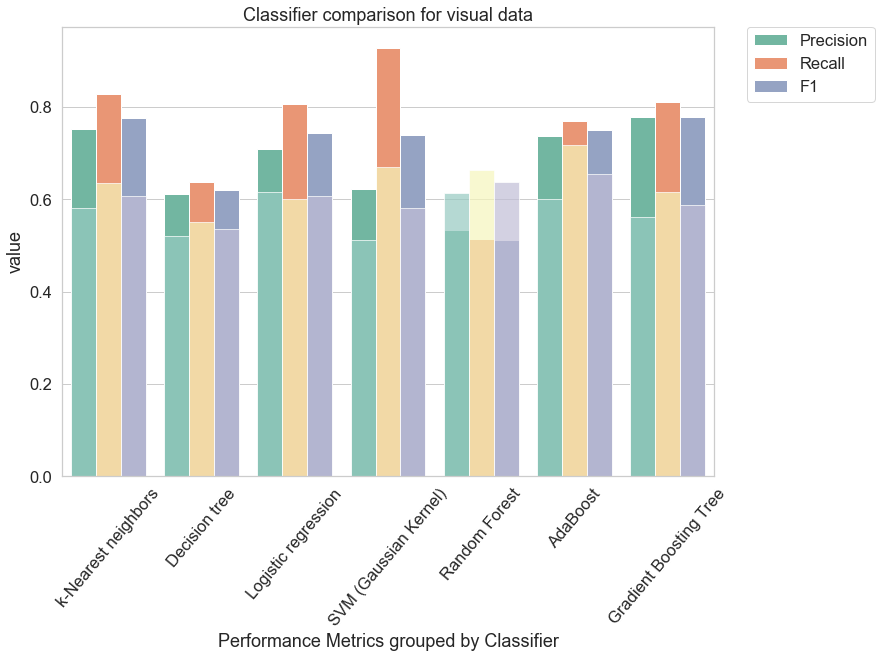

In [111]:
import warnings
warnings.filterwarnings(action='ignore')
### Balkendiagramm
df = df_visual

import scipy as sp
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.5)
sns.set_palette(sns.color_palette("Set2"))

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(ax = ax, x="Classifier_Modality", y="value", hue="variable", data=df, alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation= 50)


sns.set_palette(sns.color_palette("Set3"))
sns.barplot(ax = ax, x="Classifier_Modality", y="paper", hue="variable", data=df, alpha=0.7)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Precision", "Recall", "F1"], bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
ax.set(xlabel='Performance Metrics grouped by Classifier')
ax.set(ylabel='value')
ax.set_title('Classifier comparison for visual data')

fig.savefig("feature_clf_visual.pdf",bbox_inches="tight")

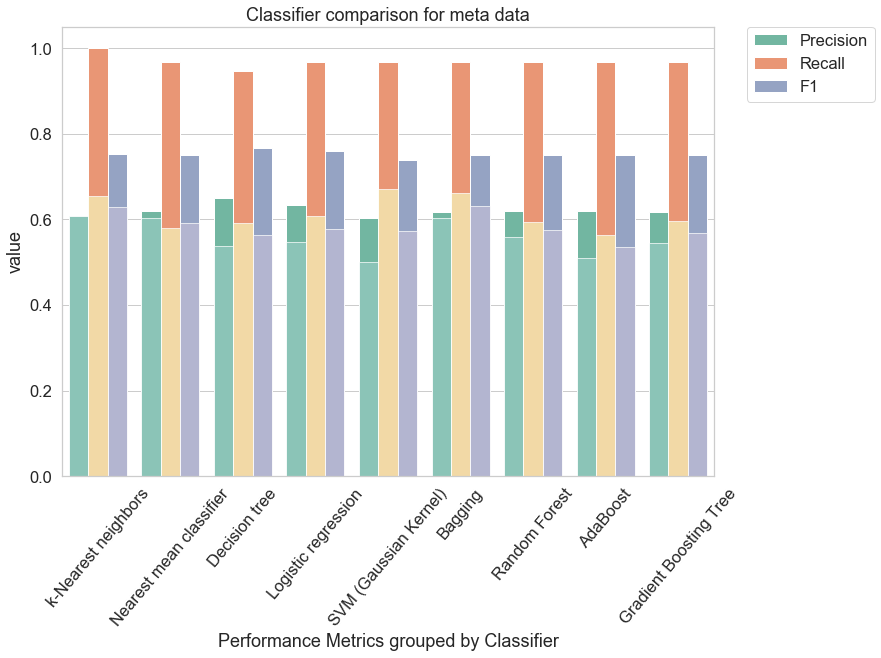

In [110]:
import warnings
warnings.filterwarnings(action='ignore')
### Balkendiagramm
df = df_meta

import scipy as sp
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.5)
sns.set_palette(sns.color_palette("Set2"))

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(ax = ax, x="Classifier_Modality", y="value", hue="variable", data=df, alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation= 50)


sns.set_palette(sns.color_palette("Set3"))
sns.barplot(ax = ax, x="Classifier_Modality", y="paper", hue="variable", data=df, alpha=0.7)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Precision", "Recall", "F1"], bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
ax.set(xlabel='Performance Metrics grouped by Classifier')
ax.set(ylabel='value')
ax.set_title('Classifier comparison for meta data')

fig.savefig("feature_clf_meta.pdf",bbox_inches="tight")

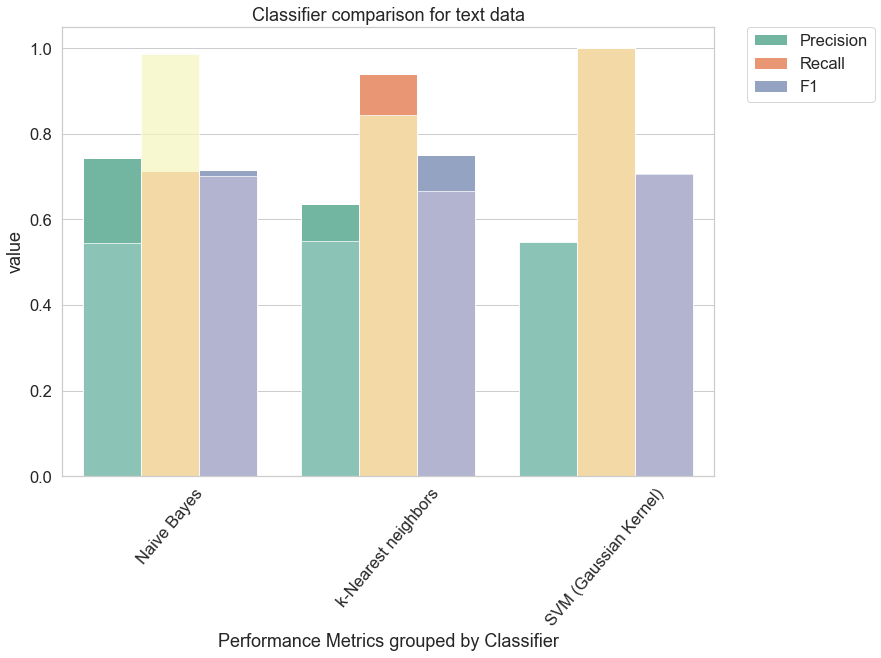

In [109]:
import warnings
warnings.filterwarnings(action='ignore')
### Balkendiagramm
df = df_text

import scipy as sp
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.5)
sns.set_palette(sns.color_palette("Set2"))

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(ax = ax, x="Classifier_Modality", y="value", hue="variable", data=df, alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation= 50)


sns.set_palette(sns.color_palette("Set3"))
sns.barplot(ax = ax, x="Classifier_Modality", y="paper", hue="variable", data=df, alpha=0.7)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Precision", "Recall", "F1"], bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
ax.set(xlabel='Performance Metrics grouped by Classifier')
ax.set(ylabel='value')
ax.set_title('Classifier comparison for text data')

fig.savefig("feature_clf_text.pdf",bbox_inches="tight")

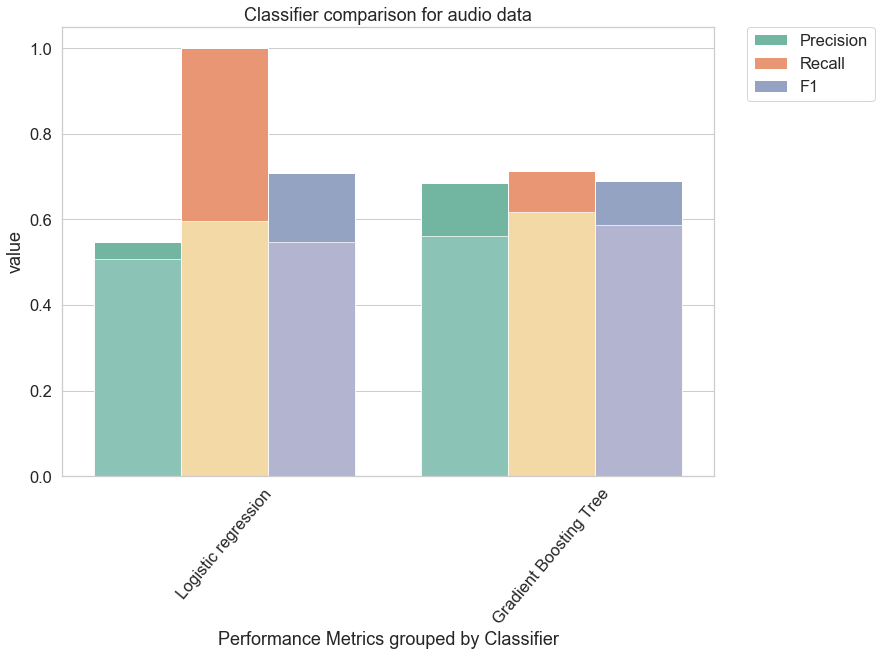

In [108]:
import warnings
warnings.filterwarnings(action='ignore')
### Balkendiagramm
df = df_audio

import scipy as sp
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.5)
sns.set_palette(sns.color_palette("Set2"))

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(ax = ax, x="Classifier_Modality", y="value", hue="variable", data=df, alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation= 50)


sns.set_palette(sns.color_palette("Set3"))
sns.barplot(ax = ax, x="Classifier_Modality", y="paper", hue="variable", data=df, alpha=0.7)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Precision", "Recall", "F1"], bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
ax.set(xlabel='Performance Metrics grouped by Classifier')
ax.set(ylabel='value')
ax.set_title('Classifier comparison for audio data')

fig.savefig("feature_clf_audio.pdf",bbox_inches="tight")